Sube el archivo CSV con los datos.


Saving preciobolsaponderado.csv to preciobolsaponderado (3).csv
Separador detectado: ','
Columnas encontradas: ['CodigoVariable', 'Fecha', 'CodigoDuracion', 'UnidadMedida', 'Version', 'Valor']
Filas leídas: 3684
No se detectaron filas con errores.


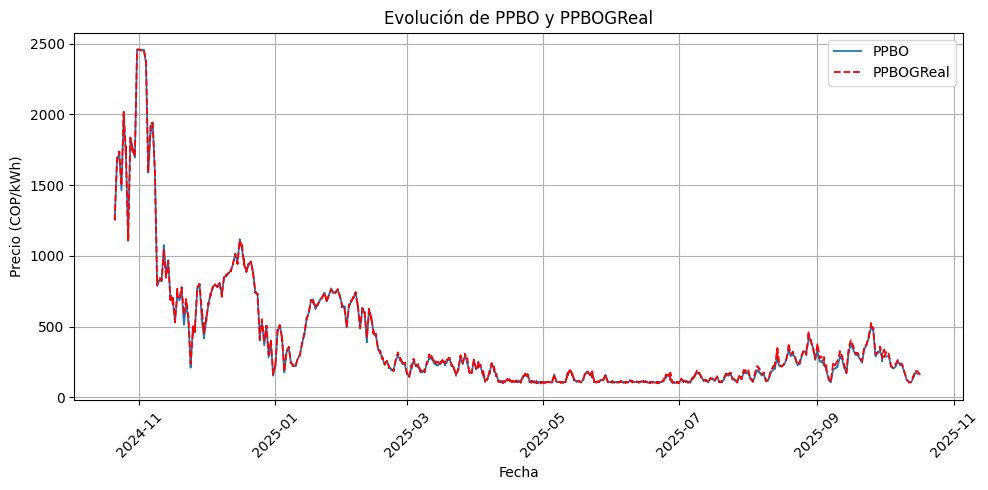

Rango de fechas: 2024-10-21 → 2025-10-18


In [8]:
# Autor: Jose Manuel Criollo Chapal
# Lectura y análisis de datos de PPBO y PPBOGReal desde archivo CSV

import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import io, csv

# Subir archivo CSV
print("Sube el archivo CSV con los datos.")
uploaded = files.upload()
archivo = list(uploaded.keys())[0]
texto = open(archivo, "rb").read()

# Detección automática del separador
try:
    sample = texto[:8192].decode(errors="ignore")
    dialect = csv.Sniffer().sniff(sample, delimiters=",;|\t")
    sep = dialect.delimiter
except Exception:
    sep = ","
print("Separador detectado:", repr(sep))

# Leer CSV como texto
df = pd.read_csv(io.BytesIO(texto), sep=sep, dtype=str, encoding="utf-8", engine="python")

print("Columnas encontradas:", df.columns.tolist())
print("Filas leídas:", len(df))

# Verificación básica
if "Fecha" not in df.columns or "Valor" not in df.columns or "CodigoVariable" not in df.columns:
    print("El archivo debe tener las columnas: Fecha, Valor y CodigoVariable.")
else:
    df["Fecha_raw"] = df["Fecha"].astype(str)
    df["Valor_raw"] = df["Valor"].astype(str)

    # Conversión de fechas
    formatos = ["%Y-%m-%d", "%d/%m/%Y", "%d-%m-%Y", "%m/%d/%Y"]
    def parse_fecha(s):
        s = str(s).strip()
        if s == "" or s.lower() in ["nan", "none", "nat"]:
            return pd.NaT
        for fmt in formatos:
            try:
                return pd.to_datetime(s, format=fmt)
            except Exception:
                pass
        return pd.to_datetime(s, dayfirst=True, errors="coerce")

    df["Fecha"] = df["Fecha_raw"].apply(parse_fecha)

    # Limpieza de valores numéricos
    df["Valor"] = df["Valor_raw"].str.replace(r"[^\d,\.\-]", "", regex=True) \
                                .str.replace(",", ".") \
                                .str.strip()
    df["Valor"] = pd.to_numeric(df["Valor"], errors="coerce")

    # Mostrar filas problemáticas
    problemas = df[df["Fecha"].isna() | df["Valor"].isna()]
    if not problemas.empty:
        print(f"Filas con errores detectadas: {len(problemas)}")
        display(problemas.head(10)[["CodigoVariable","Fecha_raw","Valor_raw"]])
    else:
        print("No se detectaron filas con errores.")

    # Filtrar y ordenar datos válidos
    df_ok = df.dropna(subset=["Fecha","Valor"]).sort_values("Fecha")

    # Filtrar variables y graficar
    ppbo = df_ok[df_ok["CodigoVariable"] == "PPBO"]
    ppbog = df_ok[df_ok["CodigoVariable"] == "PPBOGReal"]

    if ppbo.empty and ppbog.empty:
        print("No hay registros válidos de PPBO ni PPBOGReal.")
    else:
        plt.figure(figsize=(10,5))
        if not ppbo.empty:
            plt.plot(ppbo["Fecha"], ppbo["Valor"], label="PPBO", linewidth=1.3)
        if not ppbog.empty:
            plt.plot(ppbog["Fecha"], ppbog["Valor"], label="PPBOGReal", linewidth=1.3, linestyle="--", color="red")
        plt.title("Evolución de PPBO y PPBOGReal")
        plt.xlabel("Fecha")
        plt.ylabel("Precio (COP/kWh)")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        print("Rango de fechas:", df_ok["Fecha"].min().date(), "→", df_ok["Fecha"].max().date())


El método del archivo CSV resulta más sencillo para un primer acercamiento, ya que permite revisar los datos de manera local antes de analizarlos. Sin embargo, exige más cuidado con los formatos de fecha, separadores y tipos de datos. Este proceso enseña la importancia de la limpieza y validación previa a la visualización, mostrando cómo los mismos datos pueden comportarse distinto dependiendo de su origen y preparación.